### **Prior to running the code, clone detr into your local machine/drive into the face crops detr folder and make sure that it can be accessed via the ls command**
https://github.com/facebookresearch/detr



In [6]:
%ls -a
# detr/ should be present, in addition to face-crops.ipynb and checkpoints/

checkpoints/  face-crops.ipynb  __pycache__/  trained.pth
detr/         image.jpeg        test.pth


In [9]:
import os
os.chdir('./detr/')

In [10]:
# Import required libraries
import argparse
import random
from pathlib import Path
import util.misc as utils

import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import PIL.Image

from models import build_model
from main import get_args_parser

os.chdir(os.getcwd().replace('detr', ''))
from checkpoints import trainedweights


trainedweights()
parser = argparse.ArgumentParser(description="DETR Args Parser", parents=[get_args_parser()])
args = parser.parse_args(args=[])
args.resume = 'trained.pth'
args.device = 'cpu'

if args.output_dir:
  Path(args.output_dir).mkdir(parents=True, exist_ok=True)

args.distributed = False
model, criterion, postprocessors = build_model(args)

device = torch.device(args.device)
model.to(device)
output_dir = Path(args.output_dir)
##new block

output_dir = Path(args.output_dir)
if args.resume:
  
  checkpoint = torch.load(args.resume, map_location='cpu')
  model.load_state_dict(checkpoint['model'], strict=True)
model.load_state_dict(checkpoint['model'], strict=True)
##new block
COLORS = [[1.000,1.000,1.000]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
CLASSES = [
   'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
   'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
   'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
   'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
   'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
   'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
   'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
   'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
   'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
   'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
   'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
   'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
   'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
   'toothbrush'
]
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# Rescale bounding boxes to be full size of the image
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def detect(im, model, transform):
  # Mean-STD Normalize the input image (of batch-size 1)
  img = transform(im).unsqueeze(0)
  # The demo model only supports images with aspect ratios between 0.5 and 2.0
  # If you want to use images with an aspect ratio outside this range,
  # Resize the image so the maximum size is at most 1333 for best results
  assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'Demo model only supports images up to 1600 on each side.'
  # Propogate through the model on the input image
  outputs = model(img)
  # Keep only the predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0,:,:-1]
  keep = probas.max(-1).values > 0.7
  # Convert bboxes from [0;1] scale to image scale
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  # Return probabilities and scaled bboxes
  return probas[keep], bboxes_scaled


def plot_results(pil_img, class_probs, b_boxes, show, classes, is_ground_truth=False):
    plt.figure(figsize=(12,6))
    plt.axis('on')
    ax = plt.gca()
    ax.imshow(pil_img)
    measurements = []
    for p, (xmin, ymin, xmax, ymax), c in zip(class_probs, b_boxes, COLORS * 100):
        cl = p if is_ground_truth else p.argmax()
        
        # If the class isn't present, skip this annotation
        if CLASSES[cl] not in classes:
            continue
        # Plot bounding box and label (Note difference in bounding box format, xmax vs xmax-xmin)
        xmax = xmax if is_ground_truth else xmax-xmin
        ymax = ymax if is_ground_truth else ymax-ymin
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax, ymax, fill=False, color=c, linewidth=3))
        measurements.append(plt.Rectangle((xmin, ymin), xmax, ymax))
    # Show the plot
    if(show):
      plt.show()

    return [[x.get_xy(), x.get_width(), x.get_height()] for x in measurements]

Downloading...
From: https://drive.google.com/uc?id=1-58Yo7ufnAIIvSEf9apoM77KzhOoiKMQ
To: /content/drive/MyDrive/face-crops/trained.pth
100%|██████████| 497M/497M [00:05<00:00, 98.4MB/s]
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/content/drive/MyDrive/face-crops/detr/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


[[(548.7721557617188, 448.0621337890625), 33.494384765625, 31.1513671875],
 [(364.7829895019531, 447.7348327636719), 42.47021484375, 45.403411865234375],
 [(393.9574279785156, 32.79698944091797),
  18.393035888671875,
  18.884441375732422],
 [(632.079345703125, 74.54086303710938), 19.85211181640625, 22.13408660888672],
 [(626.5051879882812, 70.66508483886719),
  23.1038818359375,
  27.429397583007812],
 [(599.632568359375, 64.12786102294922), 20.2843017578125, 28.067047119140625],
 [(307.4753723144531, 56.694034576416016),
  21.1412353515625,
  29.138912200927734],
 [(463.8638916015625, 155.995361328125), 20.965576171875, 24.402267456054688],
 [(619.3236083984375, 66.85881805419922),
  21.11212158203125,
  23.59404754638672],
 [(784.2395629882812, 456.6957702636719), 16.1068115234375, 22.529052734375],
 [(443.82952880859375, 330.9939880371094), 39.80322265625, 47.130584716796875],
 [(439.6517639160156, 336.3516540527344),
  42.89361572265625,
  47.73516845703125],
 [(530.0643920898438,

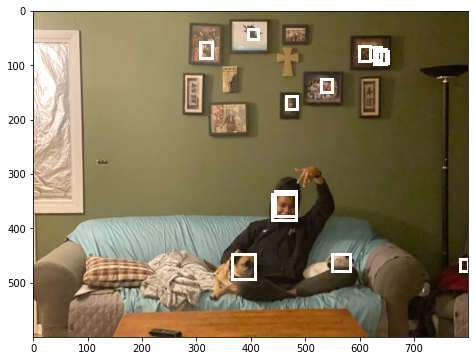

In [13]:
#image should be in the detr folder
the_image = PIL.Image.open('detr/IMG_1245.HEIC').convert('RGB').resize((800,600)) 
scores, boxes = detect(the_image, model, transform)
plot_classes = ['person']
plot_results(the_image, scores, boxes.tolist(), False, plot_classes) #returns 2d array with each elem containing (x,y), width, and height for each face crop